In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

from sklearn.metrics import f1_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

In [2]:
# importing the data set 
data = pd.read_csv("../input/Reviews.csv")


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Since we are doing sentimental analysis here,first we have to divide our reviews into positve and neagtive. So it would be benificial if we remvove neutral reviews or reviews with score 3

In [4]:
data = data[data["Score"] != 3]
print(data.shape)

(525814, 10)


In [5]:
def new_score(y):
    
    if y < 3:
        return 0
    else:
        return 1
    
       
data['new_score'] = data['Score'].map(new_score)

data.drop('Score',axis=1,inplace=True)


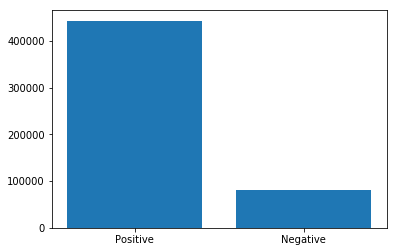

In [6]:
values = data["new_score"].value_counts()
plt.bar(("Positive","Negative"),(values[1],values[0]))
plt.show()

This shows that our data is higly imbalance .There are two options 

1)Oversampling - Creating more samples of minor class

2)Undersampling - Reducing the sampled of major class

Since that data is large,here I will be taking a sample which has 50% of positives and 50% of negatives reviews

In [7]:
values

1    443777
0     82037
Name: new_score, dtype: int64

Therefore i will be taking 20,000 samples of positive samples and 20,000 of negative samples

In [8]:
neg_rev= data[data["new_score"] == 0][:25000]
pos_rev = data[data["new_score"] ==1][:25000]

In [9]:
data_50 = pd.concat((neg_rev,pos_rev),axis=0)

In [10]:
data_50.shape

(50000, 10)

Lets sort data acoorinf to productID

In [11]:
data_50 = data_50.sort_values("ProductId")

In [12]:
# This gives the rows which are duplicated on the bases if text
data_50[data_50.duplicated("Text")]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,new_score
15030,15031,B0000CDBRZ,A253F3QA4WHGXU,"Robert Hefferle ""HEFF""",1,3,1319155200,Vegetable seasoning very spicy,Paul Prudhomme makes great seafood seasoning a...,0
15028,15029,B0000CDBRZ,A3C7U0DJHLBHZ3,K. Kozlowski,0,0,1330819200,best salty spice ever,What other spice would you buy in a 24 oz cont...,1
15026,15027,B0000CDBRZ,A1MUCR6OGBLH8Y,"Kathleen M. Hansen ""Rose251""",2,2,1291161600,Everyone ate their vegetables,I've been using this for at least 15 years. S...,1
15024,15025,B0000CDBRZ,A3PLR0MF3ZU141,"Michelle LInd ""Lorilou""",5,5,1257379200,Chef Paul Prudhomme's Magic Seasoning Blends,I have been using different seasonings for yea...,1
15023,15024,B0000CDBRZ,A23JL9SHTJIKZT,CAForster,6,6,1182816000,I'd be lost without this product!,Ever wonder why veggies at restaurants taste b...,1
15029,15030,B0000CDBRZ,A3VFFBBDQ8E6TM,"Terri Linzmeier ""Terri J""",0,0,1325030400,LOVE THIS STUFF,"I put it on fries, broiled veges, in stir fry,...",1
15027,15028,B0000CDBRZ,A1XL8WOEFCS1J1,Stacey S. Storck,2,2,1283644800,Chef Paul's Vegetable Magic,I love this seasoning. I use it on all of my v...,1
15025,15026,B0000CDBRZ,AVYJX4FYVF00A,Chris32,3,3,1292803200,Excellent !,The original product came with the foil seal o...,1
139373,139374,B0000CGDUK,A2PVQOXIZBW0S8,Kimberly Alcibiade,1,2,1344384000,Not worth it.,This coffee tastes like any other. I highly do...,0
139377,139378,B0000CGDUK,A3TP5Y45OWOFCH,V. LAMET,2,8,1240876800,Disappointed,I was disappointed because I didn't pay attent...,0


In [13]:
# Lets look into a row 
data[data["UserId"] == "A253F3QA4WHGXU"]


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,new_score
15030,15031,B0000CDBRZ,A253F3QA4WHGXU,"Robert Hefferle ""HEFF""",1,3,1319155200,Vegetable seasoning very spicy,Paul Prudhomme makes great seafood seasoning a...,0
15043,15044,B0000CDBRY,A253F3QA4WHGXU,"Robert Hefferle ""HEFF""",1,3,1319155200,Vegetable seasoning very spicy,Paul Prudhomme makes great seafood seasoning a...,0
15370,15371,B0000CDBRP,A253F3QA4WHGXU,"Robert Hefferle ""HEFF""",0,0,1319155200,BEST SEAFOOD SEASONING AVAILABLE,Have used Paul Prudhomme's Seafood Seasoning f...,1
238347,238348,B0057JF92S,A253F3QA4WHGXU,"Robert Hefferle ""HEFF""",0,0,1350864000,QUINN POPCORN,Tried Lemon & Sea Salt and Parmesan & Rosemary...,0
387295,387296,B0000CDBRQ,A253F3QA4WHGXU,"Robert Hefferle ""HEFF""",0,0,1319155200,BEST SEAFOOD SEASONING AVAILABLE,Have used Paul Prudhomme's Seafood Seasoning f...,1
387353,387354,B0000CDBRN,A253F3QA4WHGXU,"Robert Hefferle ""HEFF""",0,0,1327276800,SALMON MAGIC,I really like all Paul Prudhomme seasonings. S...,1
387371,387372,B0000CDBRM,A253F3QA4WHGXU,"Robert Hefferle ""HEFF""",0,0,1327276800,SALMON MAGIC,I really like all Paul Prudhomme seasonings. S...,1
523795,523796,B0062MZU3W,A253F3QA4WHGXU,"Robert Hefferle ""HEFF""",0,0,1327276800,SALMON MAGIC,I really like all Paul Prudhomme seasonings. S...,1


If we saw the purchases of the userID  - "A253F3QA4WHGXU" . Many comments are repeated .
One may be curious to know that why is text dupicated. We see that the ProductId is different 
Well these are the products for purchased - 
https://www.amazon.com/Magic-Seasoning-Blends-BHBUST051718A3997-Vegetable/dp/B0000CDBRY

https://www.amazon.com/Magic-Seasoning-Blends-BHBUST051718A3997-Vegetable/dp/B0000CDBRZ
This implies that the consumer bought those variants of the product and review is displayed for both the products 
ie.different variants of the product.

In [14]:
data_50=data_50.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

HelpfulnessNumerator can't be greater than HelpfulnessDenominator.
As
HelpfulnessNumerator = Number of users who found the review helpful
HelpfulnessDenominator =Number of users who indicated whether they found the review helpful or not


In [15]:
data_50=data_50[data_50.HelpfulnessNumerator<=data_50.HelpfulnessDenominator]

In [16]:
# Creating a backup
raw = data_50

# Text Processing

Now we will process our most important feature "Text". The Preprocessing here is done in 3 stages 

1)RegexpTokenizer - This helps us to filter our data .Since we don't want our text to have html tags and punctuation marks .  

2)Stop Words -  Some words like 'the','a','not' are very frequent in our language . Therefore we remove them 
Caution ! Here if we remove negation such as not,don't might change the meaning of the sentence. Therefore we will avoid removing them

3)Stemming - In order to simplify our text we will use stemming. For examaple running,runs,run after stemmming becomes run.This helps to compress our text . 

In [17]:
tokenizer = RegexpTokenizer("[a-zA-Z@]+") # We only want words in text as punctuation and numbers are not helpful
en_stopwords = set(stopwords.words("english"))
ss = SnowballStemmer("english")


stop = stopwords.words('english') 

excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]

In [18]:
def clean_up(sentence):
    
    
    sentence  = tokenizer.tokenize(sentence) # Conerting in regualr expression
    sentence = [ss.stem(w) for w in sentence if w not in stop  ]  # Stemming and removing stop words
    return " ".join(sentence) # returning the sentence in the form of a string

In [19]:
data_50["Clean_Text"] = data_50["Text"].apply(clean_up)

In [20]:
print("Text === ",data_50["Text"][1])
print("*"*100)
print("Clean_Text === ",data_50["Clean_Text"][1])

Text ===  Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
****************************************************************************************************
Clean_Text ===  product arriv label jumbo salt peanut peanut actual small size unsalt not sure error vendor intend repres product jumbo


In [21]:
X = data_50["Clean_Text"]
y = data_50["new_score"]

In [22]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size = 0.3,random_state=2)

In [23]:
print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

print("Train Data Size: ",Y_train.shape)
print("Test Data Size: ",Y_test.shape)

Train Data Size:  (31057,)
Test Data Size:  (13311,)
Train Data Size:  (31057,)
Test Data Size:  (13311,)


# BOW 

In [24]:
count_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn

X_train_bow = count_vect.fit_transform(X_train) #
X_test_bow = count_vect.transform(X_test)#
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (31057, 590108)
the number of unique words  590108


In [25]:
from sklearn import preprocessing
X_train_bow = preprocessing.normalize(X_train_bow)
X_test_bow = preprocessing.normalize(X_test_bow)

Since amazon is an internet company .The data is constantly being generated in the form of reviews here. Therefore TimeSeriesSplit would advantageous here.

This is not the regular k-fold cross validation.
It requires training with gradually more and more data
The performance is computed using the mean of all the folds, like k-fold cross validation
As more and more (or less and less) data is used by time series cross validation, it is common to find models having significantly worse scores than models with lot of data
It allows to find structural changes in data

In [26]:
tscv = TimeSeriesSplit(n_splits=10)

For Logistic Regression RandomizedSearchCV works better than GridSearchCv.

Here I am taking "Precision" as the metric .The reason for such is ,Amazon would be more concerned about the products with negative reviews rather than positive reviews. This means we do not want to predict any review   positive which is actually negative i.e Fasle Postive.Our aim would be to reduce False Positives . 

Precision = TP/TP+FP

If False Positive is less then our precision will increase.Therefore here my objective is to increase precision

In [27]:
tuned_parameters = { 'C': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_precision = RandomizedSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = "precision", n_jobs = -1)
model_precision.fit(X_train_bow, Y_train)

print("Best C and penalty",model_precision.best_params_)
print("precision on train data",model_precision.best_score_*100)

Best C and penalty {'penalty': 'l2', 'C': 100}
precision on train data 89.85754866870302


Well here our optimal λ is 10000 with L2 regularistion

In [28]:
clf_bow = LogisticRegression(C = 10000,penalty="l2")
clf_bow.fit(X_train_bow,Y_train)
pred_train =clf_bow.predict(X_train_bow)
pred_test = clf_bow.predict(X_test_bow)





In [29]:
pred_train_proba = clf_bow.predict_proba(X_train_bow)
pred_test_proba = clf_bow.predict_proba(X_test_bow)

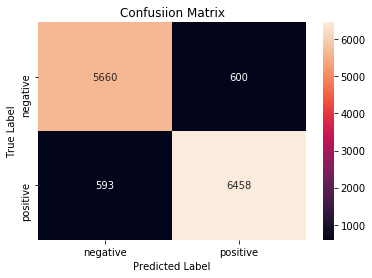

In [30]:

cm_bow = confusion_matrix(Y_test, pred_test)

import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Precision is a measure of result relevancy,
While recall is a measure of how many truly relevant results are returned.

In [31]:
print('TNR for Test = ',(cm_bow[0][0])/(cm_bow[0][0] + cm_bow[1][0]) )
print('FPR for Test = ',(cm_bow[1][0])/(cm_bow[1][0]+cm_bow[0][0]))

TNR for Test =  0.9051655205501359
FPR for Test =  0.09483447944986406


Well here my FPR is quite low which is good but this may be because of the balanced data. Let us check if we are given an imbalanced data, then what our model predicts

In [32]:
data_test = data[70000:80000]
data_test["Clean_review"] = data_test["Text"].apply(clean_up)


In [33]:
X_test_bow_1 = count_vect.transform(data_test["Clean_review"])
y1 = data_test["new_score"]
X_test_bow_1 = preprocessing.normalize(X_test_bow_1)

In [34]:
pred_test_1 = clf_bow.predict(X_test_bow_1)
pred_test_1_proba = clf_bow.predict_proba(X_test_bow_1)

In [35]:
print("roc_auc_score -- ",roc_auc_score(y1,pred_test_1))
print("Precision--",precision_score(y1,pred_test_1))
print("Recall--",recall_score(y1,pred_test_1))

roc_auc_score --  0.9285855037700252
Precision-- 0.9938625750500334
Recall-- 0.88604734150113


The scores are pretty fine . That means model works well. Let us investigate into FPR and TNR

In [36]:
cm = confusion_matrix(y1, pred_test_1)
cm

array([[1547,   46],
       [ 958, 7449]])

In [37]:
print('TNR for Test = ',(cm[0][0])/(cm[0][0] + cm[1][0]) )
print('FPR for Test = ',cm[1][0]/(cm[1][0]+cm[0][0]) )

TNR for Test =  0.617564870259481
FPR for Test =  0.38243512974051896


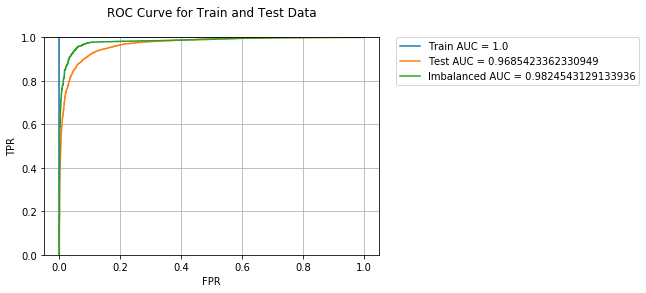

In [38]:
fpr, tpr, threshold  = roc_curve(Y_train, pred_train_proba[:,1])
fpr1, tpr1, threshold1 = roc_curve(Y_test, pred_test_proba[:,1])
fpr2, tpr2, threshold2 =roc_curve(y1,pred_test_1_proba[:,1])

plt.plot(fpr,tpr, label = 'Train AUC = ' + str(auc(fpr,tpr)))
plt.plot(fpr1,tpr1, label = 'Test AUC = '+ str(auc(fpr1,tpr1)))
plt.plot(fpr2,tpr2, label = "Imbalanced AUC = "+ str(auc(fpr2,tpr2)))


plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.title("ROC Curve for Train and Test Data\n")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Well our Bag of words Logistic regression Model seems to work fine on the imbalanced data. Though FPR should be low .

# TF IDF

In [39]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_Tfidf = vectorizer.fit_transform(X_train)
X_test_Tfidf = vectorizer.transform(X_test)

In [40]:
tuned_parameters = { 'C': [10**-4, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**4],
              'penalty':['l1','l2']}
model_precision = RandomizedSearchCV(LogisticRegression(n_jobs = -1), tuned_parameters, cv = tscv,
                     scoring = "precision", n_jobs = -1)
model_precision.fit(X_train_Tfidf, Y_train)

print("Best C and penalty",model_precision.best_params_)
print("precision on train data",model_precision.best_score_*100)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Best C and penalty {'penalty': 'l2', 'C': 10000}
precision on train data 90.47006847774625


In [41]:
clf_tf = LogisticRegression(C = 100,penalty="l2")
clf_tf.fit(X_train_Tfidf,Y_train)
pred_test_tf = clf_tf.predict(X_test_Tfidf)


In [42]:
pred_train_prob_tf = clf_tf.predict_proba(X_train_bow)
pred_test_prob_tf = clf_tf.predict_proba(X_test_bow)

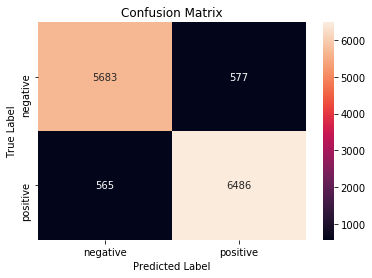

In [43]:

cm_tf = confusion_matrix(Y_test, pred_test_tf)

import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_tf, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [44]:
print('TNR for Test = ',(cm_tf[0][0])/(cm_tf[0][0] + cm_tf[1][0]) )
print('FPR for Test = ',cm_tf[1][0]/(cm_tf[1][0]+cm_tf[0][0]) )

TNR for Test =  0.9095710627400768
FPR for Test =  0.09042893725992318


In [45]:
print("Scores on Balanced Test data  ")
print("roc_auc_score -- ",roc_auc_score(Y_test,pred_test_tf))
print("Precision--",precision_score(Y_test,pred_test_tf))
print("Recall--",recall_score(Y_test,pred_test_tf))

Scores on Balanced Test data  
roc_auc_score --  0.9138484990459741
Precision-- 0.9183066685544387
Recall-- 0.9198695220536094


The metrics show us that this model is good. Let us check the model on imbanced data as done in BOW - Logistic regression


In [46]:
X_test_Tfidf_1 = vectorizer.transform(data_test["Clean_review"])


In [47]:
pred_Tfidf =clf_tf.predict(X_test_Tfidf_1 )
pred_Tfidf_proba = clf_tf.predict_proba(X_test_Tfidf_1)

In [48]:
print("Scores on Imbalanced Test data  ")
print("roc_auc_score -- ",roc_auc_score(y1,pred_Tfidf))
print("Precision--",precision_score(y1,pred_Tfidf))
print("Recall--",recall_score(y1,pred_Tfidf))

Scores on Imbalanced Test data  
roc_auc_score --  0.9310569518376571
Precision-- 0.9941520467836257
Recall-- 0.8897347448554775


In [49]:
cm = confusion_matrix(y1, pred_test_1)
cm


array([[1547,   46],
       [ 958, 7449]])

In [50]:
print('TNR for Test = ',(cm[0][0])/(cm[0][0] + cm[1][0]))
print('FPR for Test = ',cm[1][0]/(cm[1][0]+cm[0][0]))

TNR for Test =  0.617564870259481
FPR for Test =  0.38243512974051896


In [51]:
from sklearn.metrics import roc_curve

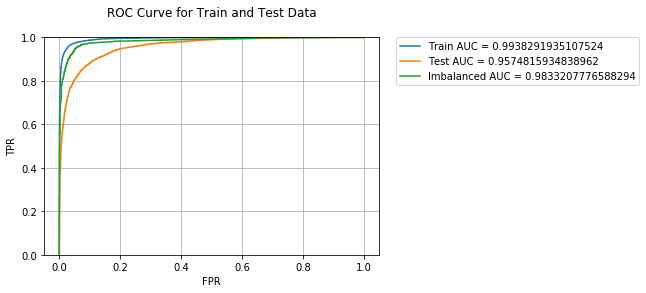

In [52]:
fpr, tpr, threshold  = roc_curve(Y_train, pred_train_prob_tf[:,1])
fpr1, tpr1, threshold1 = roc_curve(Y_test, pred_test_prob_tf[:,1])
fpr2, tpr2, threshold2 =roc_curve(y1, pred_Tfidf_proba[:,1])

plt.plot(fpr,tpr, label = 'Train AUC = ' + str(auc(fpr,tpr)))
plt.plot(fpr1,tpr1, label = 'Test AUC = '+ str(auc(fpr1,tpr1)))
plt.plot(fpr2,tpr2, label = "Imbalanced AUC = "+ str(auc(fpr2,tpr2)))


plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.title("ROC Curve for Train and Test Data\n")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

MULTI-COLLINEAR CHECK(PERTUBATION TECHNIQUE)

In [53]:
# Please write all the code with proper documentation0

LR = clf_tf
LR.fit(X_train_bow,Y_train)
weight1 = LR.coef_ # weight vector

# Getting new data set by addind a small noise
new_train = X_train_bow.astype(float)
new_train.data += np.random.uniform(-0.0001,0.0001,1 )

# Fitting the model again on new data
LR = clf_tf
LR.fit(new_train,Y_train)
weight2 = LR.coef_

# Adding small esilon to weight vector to avoid division by 0
weight1 += 10**-6
weight2 += 10**-6

percentage_change_vector = abs( (weight1-weight2) / (weight1) )*100




0 th percentile :  1.1656255605918027e-07
10 th percentile :  0.001151029501565683
20 th percentile :  0.0021609397453357148
30 th percentile :  0.0031458343665127144
40 th percentile :  0.0041970031617316736
50 th percentile :  0.005496531771925758
60 th percentile :  0.007419274231579001
70 th percentile :  0.010274666892400081
80 th percentile :  0.015111281108990265
90 th percentile :  0.025523397553095274
100 th percentile :  3573.2198112510523


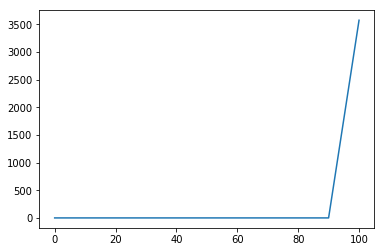

In [54]:
t = range(0,101,10)
for i in t:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

plt.plot(t,np.percentile(percentage_change_vector,t) )

In [55]:
diff = (abs(weight1 - weight2)/weight1) * 100
q = diff[np.where(diff > 30)].size
print("Percentage of features which did not change by more than 30% is :",(weight1.size - q)/weight1.size*100)

Percentage of features which did not change by more than 30% is : 99.99915269747233


Since only 1 % of feature changed their value more than 30 %. Therefore there is no multicolinearity

Lets us look at feature importance

In [56]:
LR = clf_tf
LR.fit(X_train_bow,Y_train)
feat_log = LR.coef_

vectorizer = TfidfVectorizer(ngram_range=(1,2))
p = vectorizer.fit_transform(X_train)
p = pd.DataFrame(feat_log.T,columns=['+ve'])
p['feature'] = vectorizer.get_feature_names()


In [57]:
q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
print("Top 10  important features of positive class", np.array(q['feature'][:10]))

Top 10  important features of positive class ['not disappoint' 'delici' 'excel' 'amaz' 'high recommend' 'not bitter'
 'yummi' 'addict' 'perfect' 'not bad']


In [58]:
print("Top 10  important features of negative class",np.array(q.tail(10)['feature']))

Top 10  important features of negative class ['two star' 'aw' 'not good' 'bland' 'horribl' 'not worth' 'not recommend'
 'terribl' 'worst' 'disappoint']
